Kildisuite Neuroblastoma Data - Great Ormond Street Hospital
--

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [2]:
# Read the h5ad file for neuroblastoma data
nb_data = sc.read_h5ad("/Users/davidkaplan/Desktop/neuroblastoma_data/kildisuite/nb_GOSH_cellxgene.h5ad")

#Read the h5ad file for adrenal gland data
ag_data = sc.read_h5ad("/Users/davidkaplan/Desktop/neuroblastoma_data/kildisuite/adr_all_cellxgene.h5ad")
# View the loaded data
print(ag_data)

AnnData object with n_obs × n_vars = 57972 × 33694
    obs: 'GestationalAge', 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'


| Variable | Definition|
|----------|----------|
|`n_genes_by_counts` | Represents the number of genes detected in each cell|
|`total_counts` | total number of reads detected in each cell|
|`pct_counts_mt`|Metric that is calculated later. Percentage of reads mapping to mitochondrial genes in each cell|


**Read** =  fragment of RNA that was sequenced from a single cell.

___
### <b>Highly Expressed Genes</b>

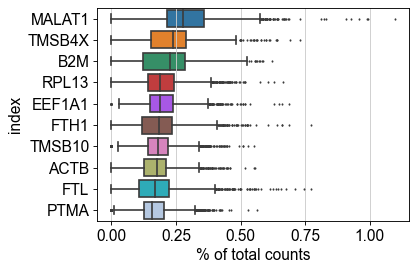

In [3]:
# NEUROBLASTOMA DATASET
sc.set_figure_params(figsize=(8,4))
sc.pl.highest_expr_genes(nb_data,n_top=10)

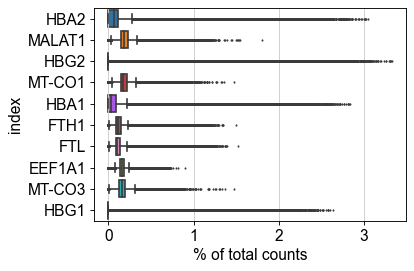

In [4]:
# ADRENAL GLAND DATASET
sc.set_figure_params(figsize=(8,4))
sc.pl.highest_expr_genes(ag_data,n_top=10)

___
### <b>Quality Control</b>
<b>Identify all the counts of mitochondria gene expression</b>
`sc.pp.calculate_qc_metrics` is used to calculate the percentage counts expressing mitochondrial genes.

In [12]:
nb_data.var['mt'] = nb_data.var_names.str.startswith('MT-')

In [13]:
sc.pp.calculate_qc_metrics(nb_data,qc_vars=['mt'],percent_top=None,log1p=False,inplace=True)

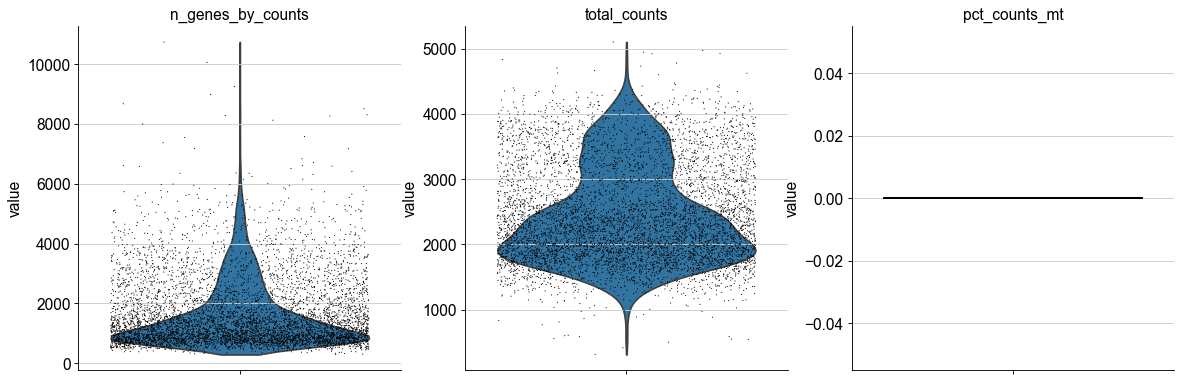

In [14]:
sc.pl.violin(nb_data,['n_genes_by_counts','total_counts','pct_counts_mt'],jitter=0.4,multi_panel=True)

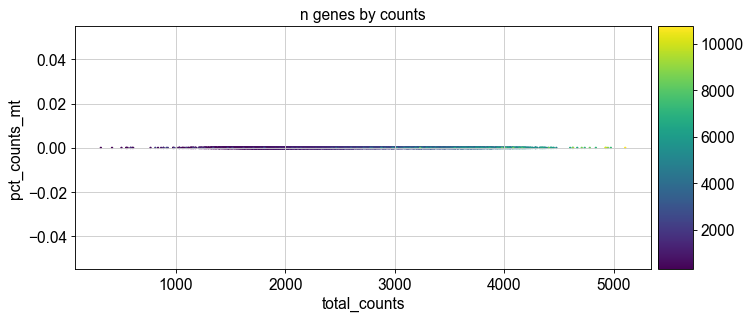

In [15]:
sc.pl.scatter(nb_data,x='total_counts',y='pct_counts_mt',color='n_genes_by_counts')

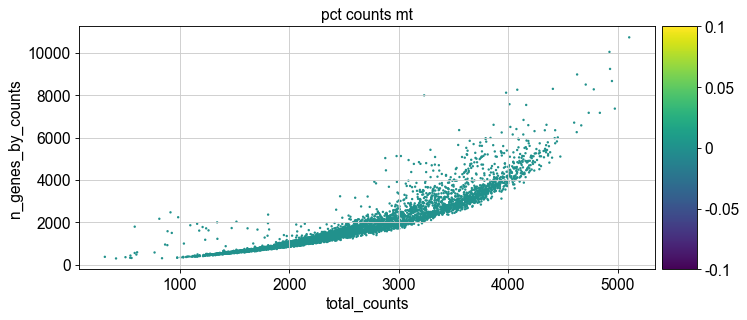

In [16]:
sc.pl.scatter(nb_data,x='total_counts',y='n_genes_by_counts',color='pct_counts_mt')

<AxesSubplot:xlabel='n_genes_by_counts'>

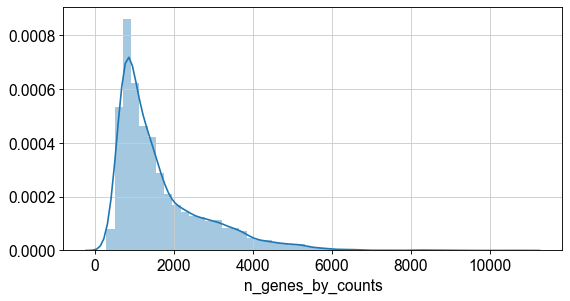

In [17]:
sns.distplot(nb_data.obs['n_genes_by_counts'])

<b>Observation: Kildisuite neuroblastoma data has low count of mitochondrial gene expression, hence the data is of high quality!</b>
___
<b>Quality Contorl on Adrenal Gland data</b>

In [18]:
ag_data.var['mt'] = ag_data.var_names.str.startswith('MT-')

In [19]:
sc.pp.calculate_qc_metrics(ag_data,qc_vars=['mt'],percent_top=None,log1p=False,inplace=True)

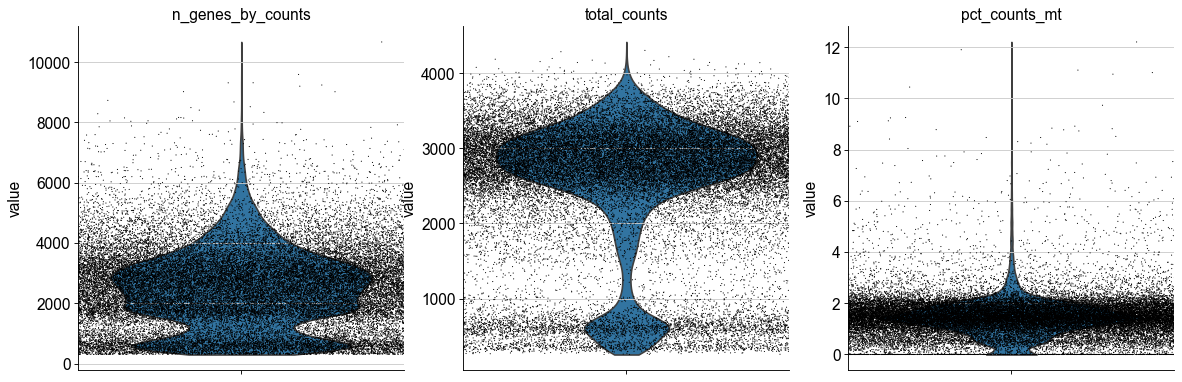

In [20]:
sc.pl.violin(ag_data,['n_genes_by_counts','total_counts','pct_counts_mt'],jitter=0.8,multi_panel=True)

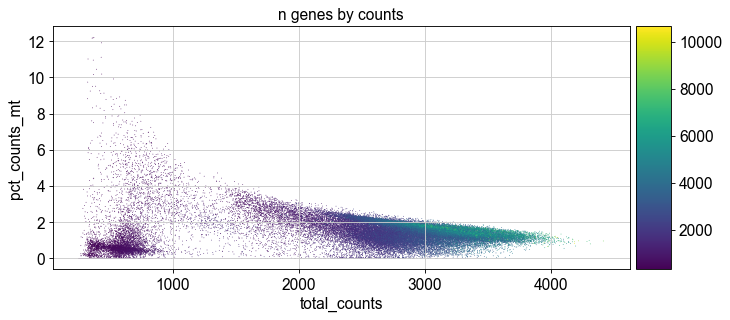

In [21]:
sc.pl.scatter(ag_data,x='total_counts',y='pct_counts_mt',color='n_genes_by_counts')

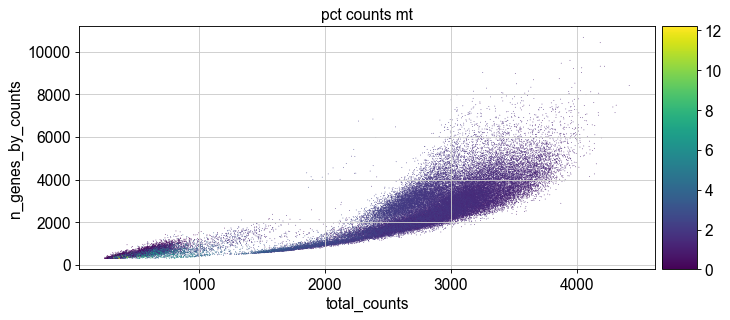

In [22]:
sc.pl.scatter(ag_data,x='total_counts',y='n_genes_by_counts',color='pct_counts_mt')

In [23]:
ag_data.X.shape

(57972, 33694)

<AxesSubplot:xlabel='n_genes_by_counts'>

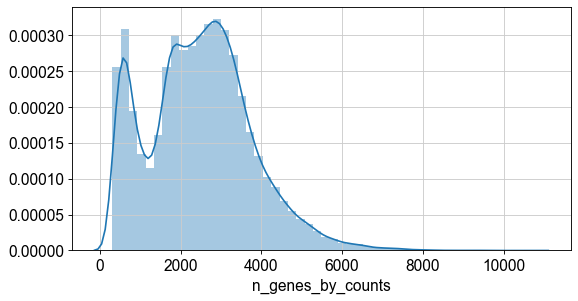

In [24]:
sns.distplot(ag_data.obs['n_genes_by_counts'])

<b>Observation: Kildisuite foetal adrenal gland data has higher count of mitochondrial gene expression, hence the data needs to be sub-setted.</b>
___

In [25]:
#Picking by quantilies - Foetal adrenal gland
upper = np.quantile(ag_data.obs.n_genes_by_counts.values, .95)
lower = np.quantile(ag_data.obs.n_genes_by_counts.values, .05)
print("Range: "+str(lower)+" to "+str(upper))

Range: 498.0 to 4685.0


### <b>Integrating and Normalizing Data</b>
___
1. Combine the datasets together `scanpy concatenate`


2. Run normalization procedure `UMI counts -> log(x+1) transformation`

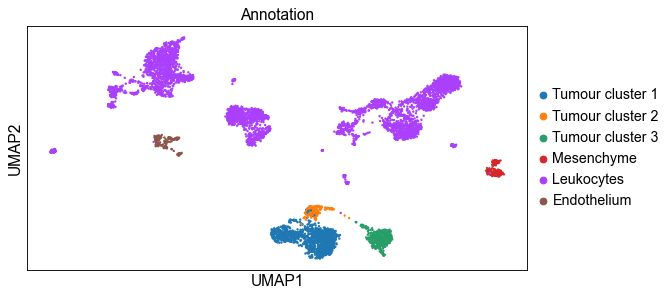

In [26]:
sc.pl.umap(nb_data,color="Annotation")

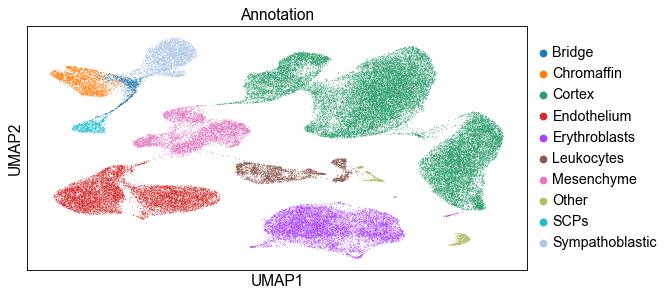

In [27]:
sc.pl.umap(ag_data,color="Annotation")

In [28]:
# ag_data = ag_data.concatenate(nb_data,batch_key='sample')
data_kildisuite = ag_data.concatenate(nb_data, batch_key='sample')

# check the shape of the combined dataset
print(data_kildisuite.shape)

(64414, 33428)


In [29]:
sc.pp.normalize_total(data_kildisuite,target_sum=1e4)
sc.pp.log1p(data_kildisuite)

... storing 'GestationalAge' as categorical
... storing 'SampleName' as categorical
... storing 'Annotation' as categorical


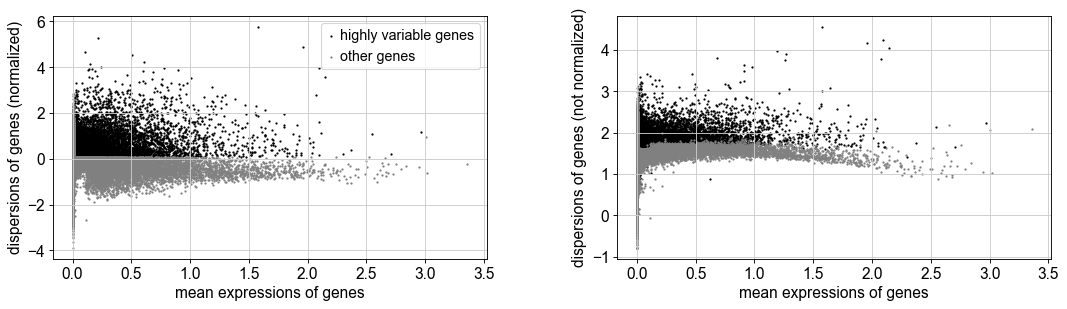

In [30]:
sc.pp.highly_variable_genes(data_kildisuite, min_mean=0.0125,max_mean=3,min_disp=0.1,batch_key='sample')
sc.pl.highly_variable_genes(data_kildisuite)

In [31]:
highly_variable_data = data_kildisuite[:,data_kildisuite.var.highly_variable]

In [32]:
highly_variable_data

View of AnnData object with n_obs × n_vars = 64414 × 8093
    obs: 'GestationalAge', 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample'
    var: 'mt', 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

In [33]:
#.copy() -> Test to see if needed
pcData = highly_variable_data

In [34]:
sc.pp.scale(pcData, max_value=10)

/usr/local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [35]:
sc.tl.pca(pcData, svd_solver='arpack')

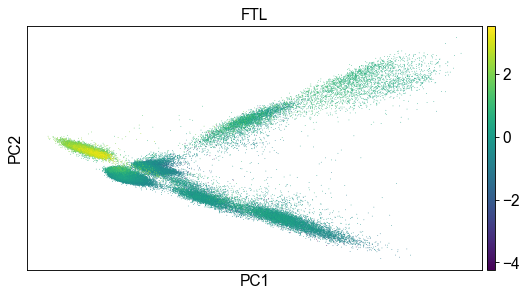

In [36]:
sc.pl.pca(pcData, color='FTL')

In [37]:
pcData.obsm["X_pca"].shape

(64414, 50)

/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


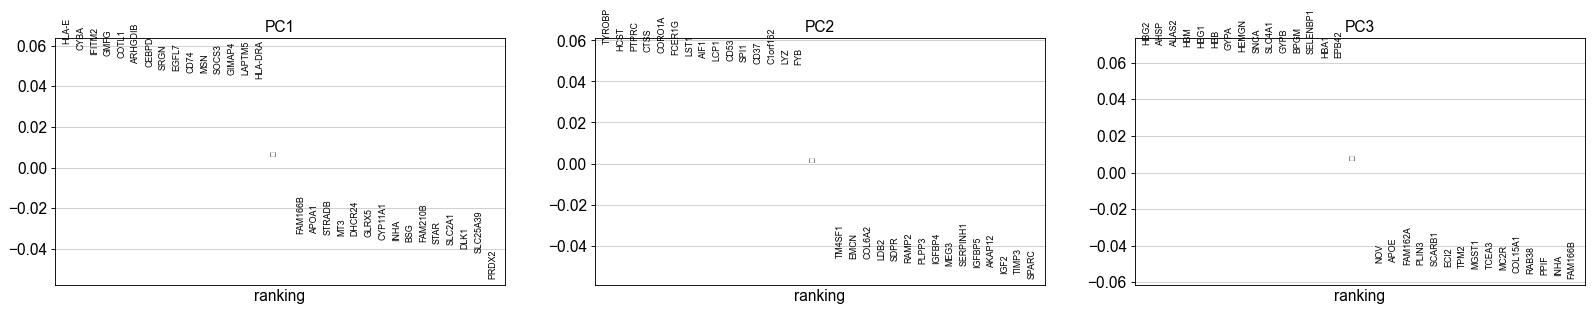

In [38]:
sc.pl.pca_loadings(pcData)

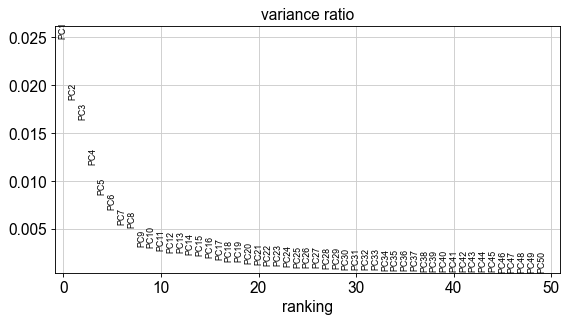

In [39]:
sc.pl.pca_variance_ratio(pcData,log=False,n_pcs=50)

In [40]:
sc.pp.neighbors(pcData)

/usr/local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
sc.tl.umap(pcData)

In [42]:
sc.tl.leiden(pcData,resolution=0.01)

In [48]:
pcData.obs.leiden[::-1]

index
STDY7787239_TTTGCGCGTCAATGTC-1     8
STDY7787239_TTTCCTCAGATGGGTC-1     8
STDY7787239_TTTATGCAGCTAGGCA-1     8
STDY7787239_TTTATGCAGCTAACTC-1     8
STDY7787239_TTTATGCAGCGGCTTC-1     8
                                  ..
babyAdrenal1_AAACCTGAGGCGCTCT-0    0
babyAdrenal1_AAACCTGAGGCACATG-0    0
babyAdrenal1_AAACCTGAGCTTCGCG-0    0
babyAdrenal1_AAACCTGAGCGATGAC-0    5
babyAdrenal1_AAACCTGAGAATTGTG-0    0
Name: leiden, Length: 64414, dtype: category
Categories (10, object): [0, 1, 2, 3, ..., 6, 7, 8, 9]

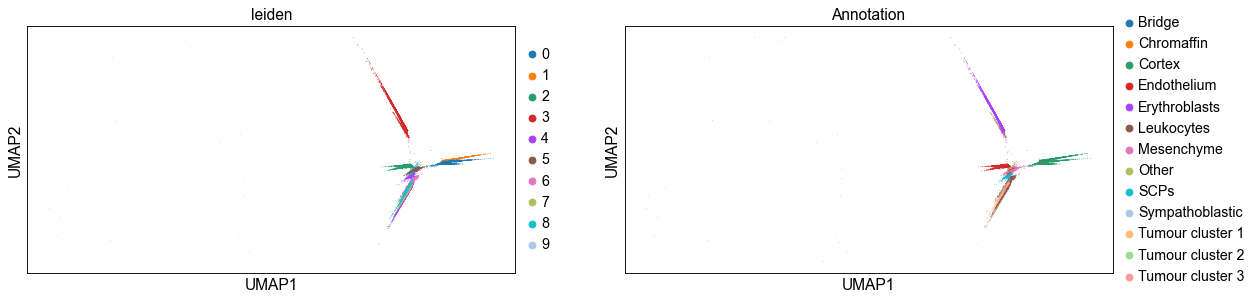

In [44]:
sc.set_figure_params(figsize=(8,4))
sc.pl.umap(pcData, color=["leiden",'Annotation'])
plt.show()

In [45]:
sc.tl.rank_genes_groups(pcData, 'leiden')

/usr/local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


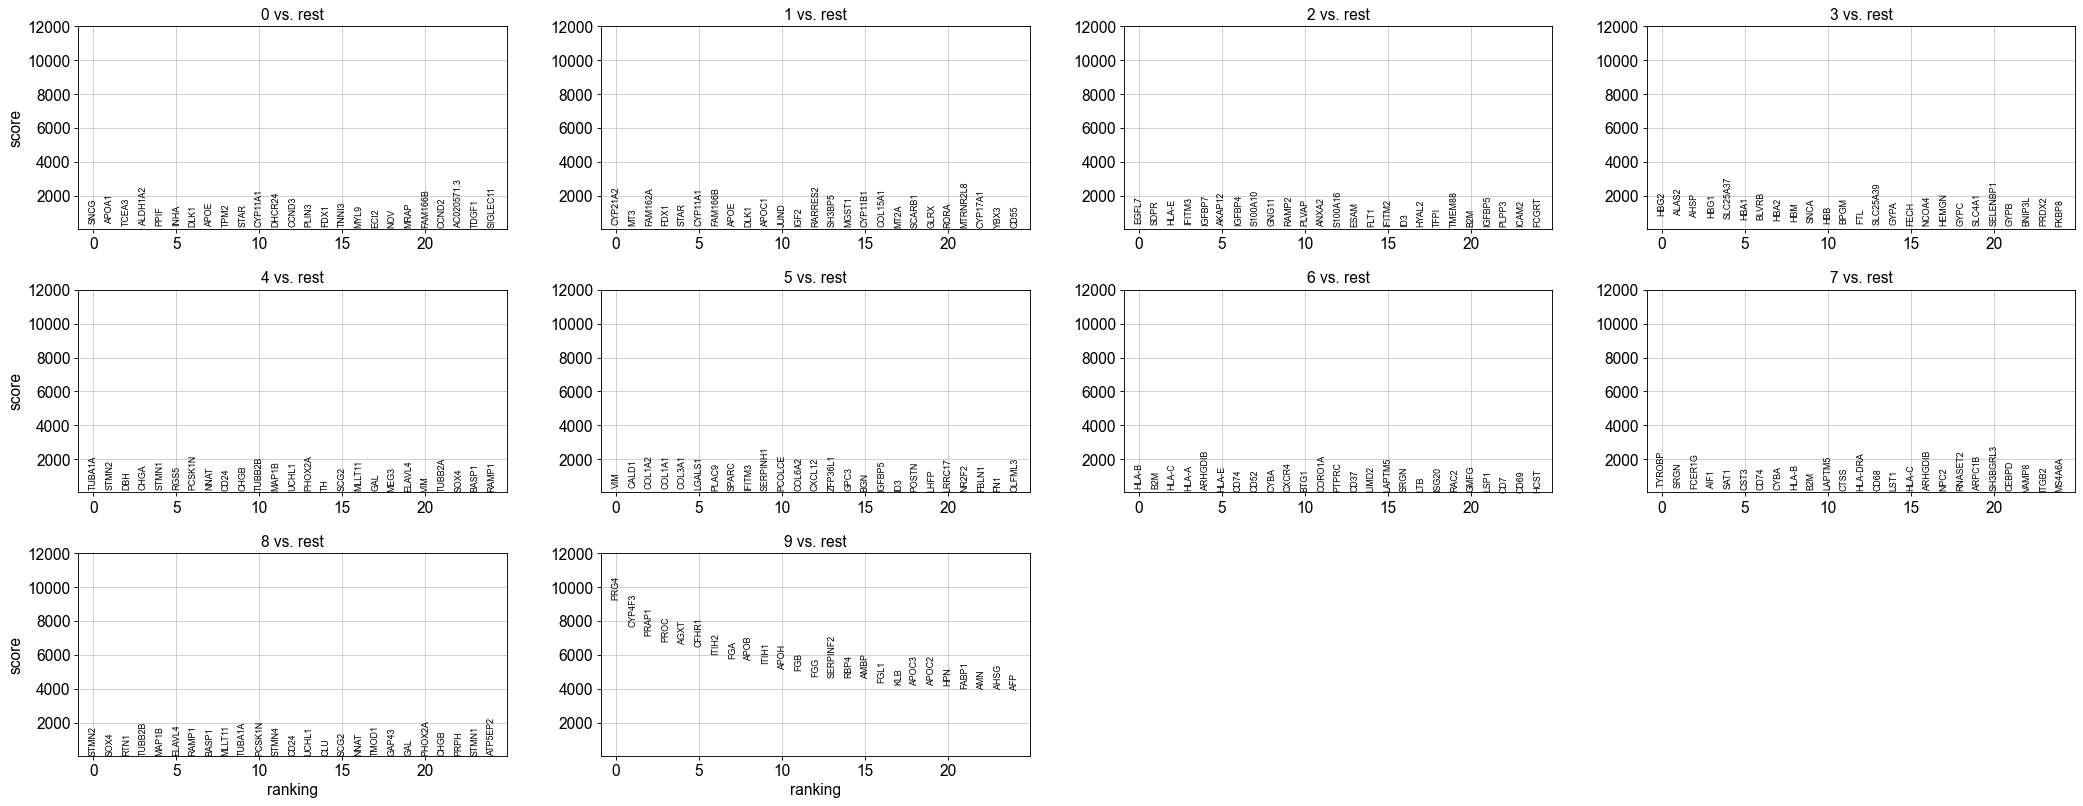

In [46]:
sc.set_figure_params(figsize=(8,4))
sc.pl.rank_genes_groups(pcData, n_genes=25)
plt.show()

In [52]:
pd.DataFrame(pcData.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9
0,SNCG,CYP21A2,EGFL7,HBG2,TUBA1A,VIM,HLA-B,TYROBP,STMN2,PRG4
1,APOA1,MT3,SDPR,ALAS2,STMN2,CALD1,B2M,SRGN,SOX4,CYP4F3
2,TCEA3,FAM162A,HLA-E,AHSP,DBH,COL1A2,HLA-C,FCER1G,RTN1,PRAP1
3,ALDH1A2,FDX1,IFITM3,HBG1,CHGA,COL1A1,HLA-A,AIF1,TUBB2B,PROC
4,PPIF,STAR,IGFBP7,SLC25A37,STMN1,COL3A1,ARHGDIB,SAT1,MAP1B,AGXT


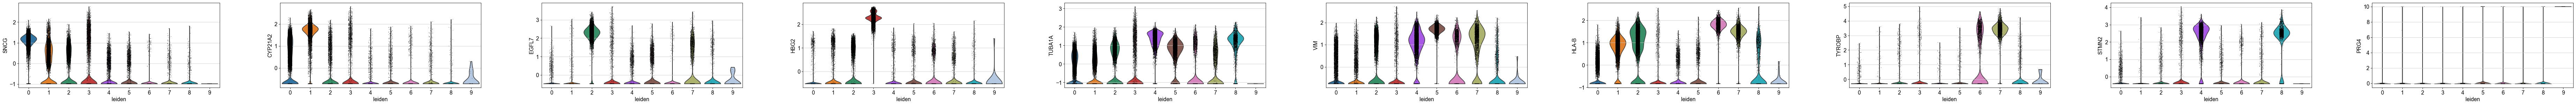

In [54]:
sc.pl.violin(pcData, ['SNCG','CYP21A2','EGFL7','HBG2','TUBA1A','VIM','HLA-B','TYROBP','STMN2','PRG4'],groupby='leiden',ncols=2)

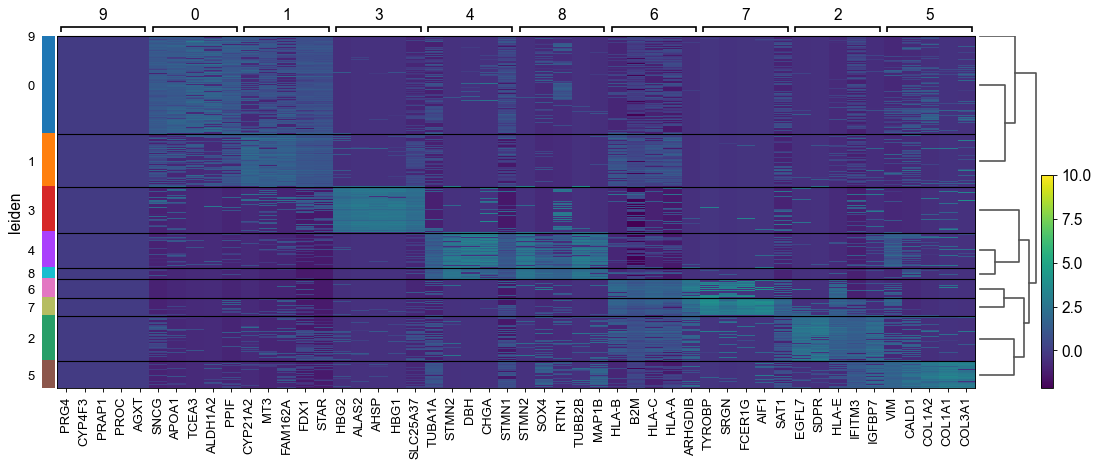

In [58]:
sc.pl.rank_genes_groups_heatmap(pcData,n_genes=5,groupby="leiden",show_gene_labels=True)

Foetal Adrenal Gland has more clusters, and so will use that as reference when integrating the data together.

In [33]:
nb_data

AnnData object with n_obs × n_vars = 6442 × 33428
    obs: 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Annotation_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

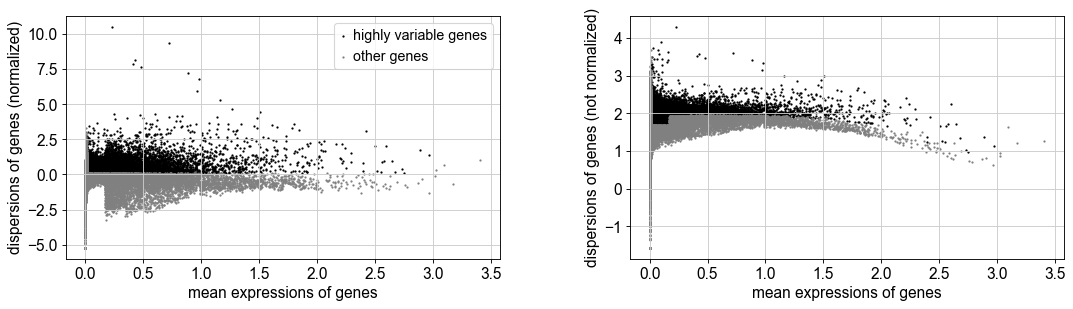

In [21]:
sc.pp.normalize_total(nb_data,target_sum=1e4)
sc.pp.log1p(nb_data)
sc.pp.highly_variable_genes(nb_data, min_mean=0.0125,max_mean=3,min_disp=0.1)
sc.pl.highly_variable_genes(nb_data)

In [22]:
nb_HVG = nb_data[:,nb_data.var.highly_variable]

In [32]:
nb_HVG

AnnData object with n_obs × n_vars = 6442 × 9375
    obs: 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Annotation_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
sc.pp.regress_out(nb_HVG, ['total_counts','pct_counts_mt'])
sc.pp.scale(nb_HVG, max_value=10)
sc.tl.pca(nb_HVG, svd_solver='arpack')

/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


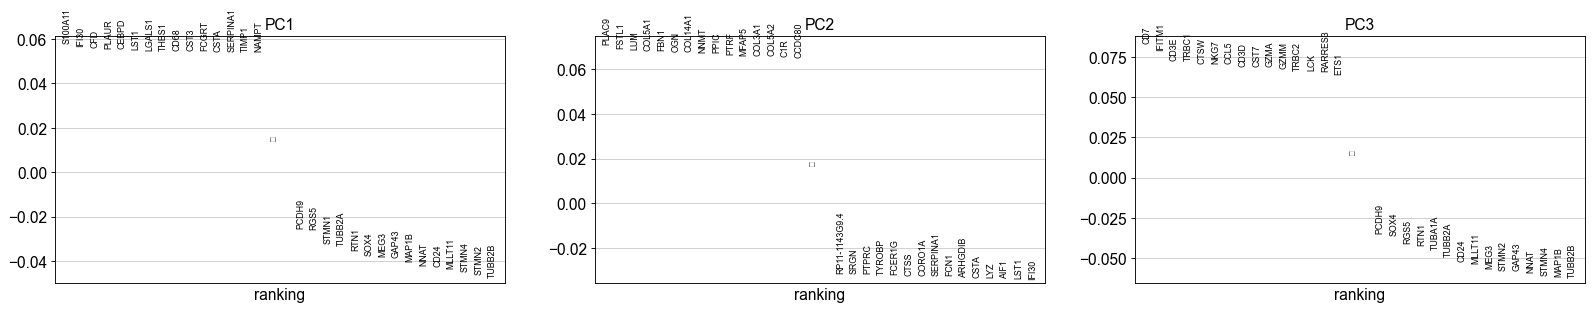

In [24]:
#PCA LOADINGS
sc.pl.pca_loadings(nb_HVG)

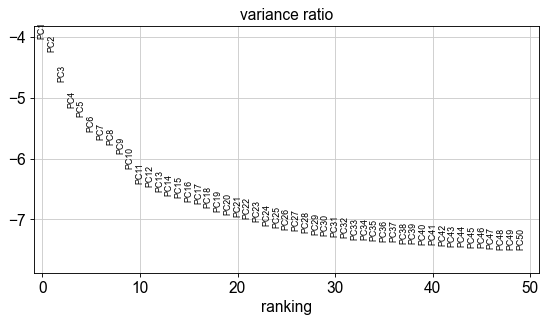

In [25]:
#PCA variance Ratio plot
sc.pl.pca_variance_ratio(nb_HVG,log=True,n_pcs=50)

In [26]:
#Calculate neighbors based of euclidean distance - UMAP
sc.pp.neighbors(nb_HVG)
sc.tl.umap(nb_HVG)

/usr/local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


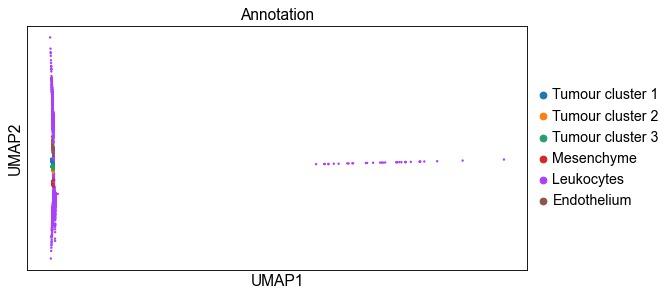

In [27]:
sc.pl.umap(nb_HVG,color="Annotation")

In [34]:
nb_HVG.obs['Sample'] = 'nb_HVG'

In [36]:
nb_HVG.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
index,,,,,,,,,,,,,,,,
RP11-34P13.7,0.004346,0.004328,0.005266,0.821859,False,False,28,0.004231,99.565352,27.256567,True,0.016262,1.862700,0.372166,3.419401e-11,0.098775
RP4-669L17.10,0.009314,0.010160,0.011974,0.848514,False,False,57,0.008441,99.115182,54.375980,True,0.030288,1.838703,0.333030,-1.839334e-11,0.134295
LINC00115,0.027010,0.027837,0.037373,0.744854,False,False,169,0.028911,97.376591,186.247604,True,0.108634,2.008674,0.610225,-7.897159e-12,0.256075
FAM41C,0.044862,0.047824,0.064184,0.745109,False,False,274,0.053346,95.746663,343.652069,True,0.205384,2.072203,0.735027,1.723279e-10,0.358922
ISG15,0.601521,4.282271,1.943479,2.203405,True,False,1958,0.549041,69.605713,3536.917969,True,1.274635,2.128276,1.148505,3.510170e-10,1.006657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.4,0.003726,0.003712,0.004452,0.833865,False,False,24,0.003646,99.627445,23.488888,True,0.013351,1.714169,0.129935,5.667965e-12,0.090226
AC145212.2,0.018317,0.026679,0.024613,1.083948,False,False,101,0.014387,98.432164,92.682892,True,0.053071,1.864738,0.375490,-1.995742e-11,0.177762
AL592183.1,0.095467,0.115555,0.147756,0.782065,False,False,549,0.107849,91.477802,694.762695,True,0.382417,2.096805,0.835558,-8.500740e-11,0.500716


In [37]:
# Adrenal Dataset

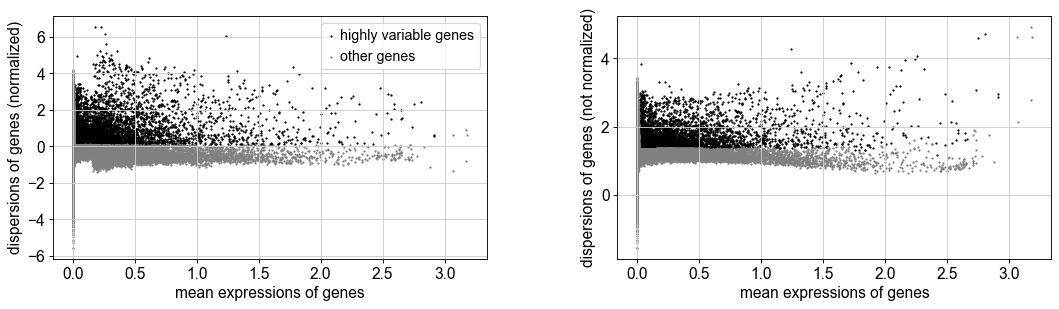

In [38]:
sc.pp.normalize_total(ag_data,target_sum=1e4)
sc.pp.log1p(ag_data)
sc.pp.highly_variable_genes(ag_data, min_mean=0.0125,max_mean=3,min_disp=0.1)
sc.pl.highly_variable_genes(ag_data)

In [41]:
ag_HVG = ag_data[:,ag_data.var.highly_variable]

In [42]:
sc.pp.regress_out(ag_HVG, ['total_counts','pct_counts_mt'])
sc.pp.scale(ag_HVG, max_value=10)
sc.tl.pca(ag_HVG, svd_solver='arpack')

/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


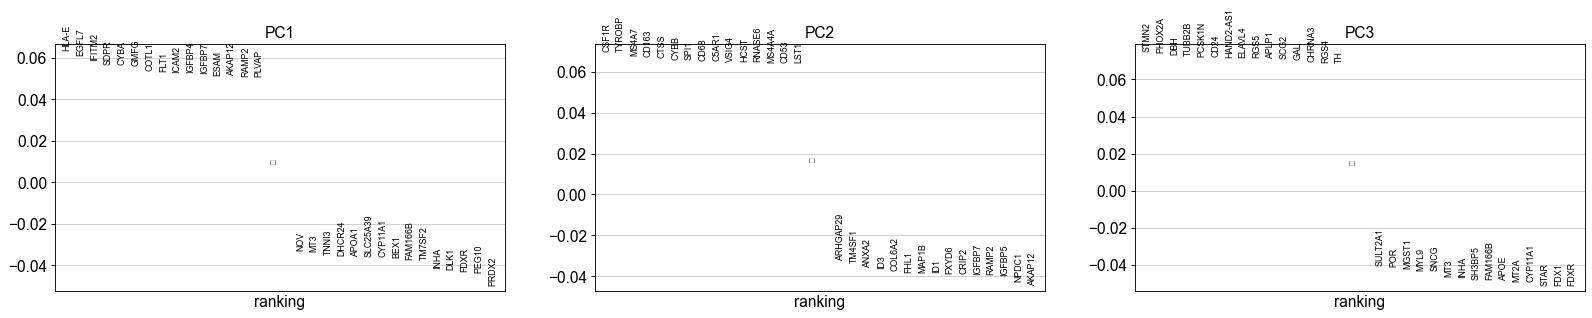

In [43]:
sc.pl.pca_loadings(ag_HVG)

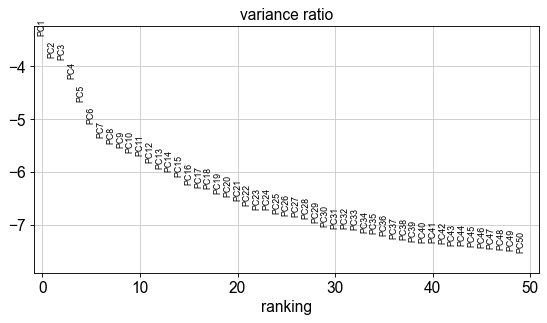

In [44]:
sc.pl.pca_variance_ratio(ag_HVG,log=True,n_pcs=50)

In [45]:
sc.pp.neighbors(ag_HVG)
sc.tl.umap(ag_HVG)

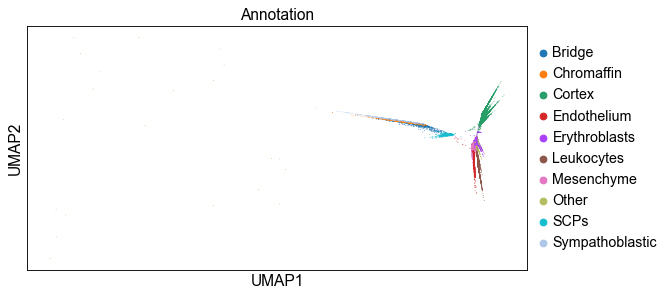

In [46]:
sc.pl.umap(ag_HVG,color="Annotation")

In [47]:
ag_HVG.obs['Sample'] = 'ag_HVG'

In [51]:
#Genes that intersect one another
var_names = ag_HVG.var_names.intersection(nb_HVG.var_names)
len(var_names)

3805

In [52]:
ag_HVG = ag_HVG[:,var_names]
nb_HVG = nb_HVG[:,var_names]

In [53]:
sc.tl.ingest(nb_HVG,ag_HVG)

In [117]:
test = ag_HVG.concatenate(nb_HVG)

In [122]:
sc.pp.neighbors(test)

In [123]:
sc.tl.leiden(test,resolution=0.01)

<IPython.core.display.Javascript object>


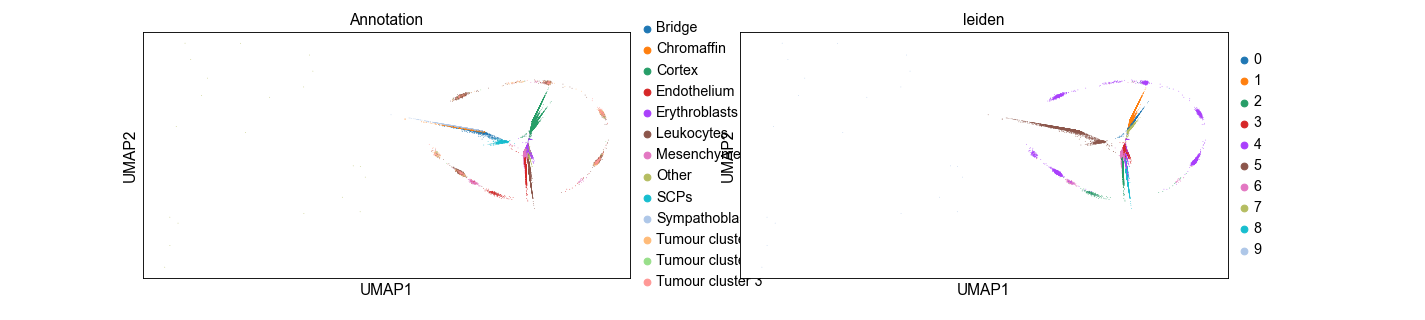

In [124]:
sc.pl.umap(test,color=['Annotation','leiden'])

In [ ]:
sc.tl.umap(pcData)

In [ ]:
pcData.obs

In [ ]:
# %matplotlib notebook
# sc.set_figure_params(figsize=(8,4))
# sc.pl.umap(pcData, color="Annotation")
# plt.tight_layout()
# plt.show()